### Formula (14) Explanation

Formula (14) represents the optimization problem of fitting a mixture of linear models to data. The goal is to minimize the sum of squared differences between the predicted values $ \hat{y}(x_n) $ and the observed values $ y_n $, where $ \hat{y}(x_n) $ is a combination of $ K $ linear models, weighted by a softmax function.

The variables to optimize are the slopes $ s_k $, intercepts $ r_k $, and the parameters $ u_k $, $ v_k $ that control the weights $ w_k(x) $, which determine how much each linear model contributes to the final prediction $ \hat{y}(x) $.

### Equations

The full set of equations needed to understand (14) is as follows:

1. **Optimization Problem (14):**

   $$
   \text{minimize}_{s_1, r_1, \dots, s_K, r_K, \, u_1, v_1, \dots, u_{K-1}, v_{K-1}} \sum_{n=1}^{N} \left( \hat{y}(x_n) - y_n \right)^2,
   \tag{14}
   $$

2. **Combined Linear Model (12):**

   The predicted value $ \hat{y}(x) $ is a weighted sum of the individual linear models:

   $$
   \hat{y}(x) = \sum_{k=1}^{K} w_k(x) \hat{y}_k(x),
   \tag{12}
   $$

3. **Individual Linear Model:**

   Each $ k $-th linear model is parameterized by a slope $ s_k $ and intercept $ r_k $:

   $$
   \hat{y}_k(x) = s_k x + r_k
   $$

4. **Weight Function (13):**

   The weight $ w_k(x) $ for each $ k $-th linear model is determined by a softmax function of the parameters $ u_k $ and $ v_k $:

   $$
   w_k(x) = \frac{e^{u_k x + v_k}}{e^{u_1 x + v_1} + \cdots + e^{u_K x + v_K}},
   \tag{13}
   $$

This weight function ensures that the weights sum to 1 across all $ K $ linear models for any value of $ x $.

### Levenberg–Marquardt (LM) Method

1. **Initialize**: Choose initial values $ x_0 \in \mathbb{R}^n $, $ \lambda_0 > 0 $, and tolerance $ \epsilon > 0 $.
2. **Set** $ k = 0 $.
3. **Repeat until convergence**:
   - Compute gradient $ g_k = \nabla f(x_k) $.
   - **Stopping criterion**: If $ \|g_k\| < \epsilon $, stop.
   - Solve for the next candidate point:
     $ \hat{x}_{k+1} = \arg \min_{x \in \mathbb{R}^n} \sum_{p=1}^{P} \left( f_p(x_k) + \nabla f_p(x_k)^T (x - x_k) \right)^2 + \lambda_k \|x - x_k\|^2 $.
   - **Update based on improvement**:
     - If $ f(\hat{x}_{k+1}) < f(x_k) $ (valid step):
       - Set $ x_{k+1} = \hat{x}_{k+1} $.
       - Update $ \lambda_{k+1} = 0.7 \lambda_k $.
     - Otherwise (null step):
       - Set $ x_{k+1} = x_k $.
       - Update $ \lambda_{k+1} = 2 \lambda_k $.
   - Increment $ k \leftarrow k + 1 $.
   
4. **End loop**.




## Task 10. [Numerical task]
Solve the optimization problem (14) by coding the Levenberg–Marquardt (LM) method as described below yourself. In particular, you need to find the gradient of the objective function analytically. For LM, start with $\lambda_0 = 1$ and stop the iterations when the norm of the gradient of $f$ falls below $\epsilon = 10^{-4}$ or a maximum of 5000 iterations is reached.

This task uses $K = 4$ and $N = 100$ and the measurements can be found in the file `data/lm_dataset_task.mat`, which contains the following column vectors:

- $x$ of length $N$ with the measurements $\{x_n : 1 \leq n \leq N\}$;
- $y$ of length $N$ with the measurements $\{y_n : 1 \leq n \leq N\}$;
- $u$ of length $K-1$ that contains values of $\{u_k : 1 \leq k \leq K\}$;
- $v$ of length $K-1$ that contains values of $\{v_k : 1 \leq k \leq K\}$;
- $s$ of length $K$ that contains values of $\{s_k : 1 \leq k \leq K\}$;
- $r$ of length $K$ that contains values of $\{r_k : 1 \leq k \leq K\}$.

Use the vectors $u$, $v$, $s$, and $r$ above as the initialization of your LM iterates.

Once your LM algorithm has converged, report the values of the vectors $u$, $v$, $s$, and $r$ to which LM converged. Also, plot the obtained linear mixture (12) and the weights as a function of the time instants $x_n$ in the dataset. Finally, plot both the objective function of (14) and its gradient across the LM iterates. Comment on the results you observe.

### An important numerical technique. 

Suppose you are given real numbers $ \alpha_1, \dots, \alpha_K $ and you want to compute

$$
\frac{e^{\alpha_k}}{e^{\alpha_1} + \cdots + e^{\alpha_K}},
$$

for some $ 1 \leq k \leq K $. Such kind of computation appears, for example, in (13). If some $ \alpha_i $ is large enough, the exponential of such $ \alpha_i $ may overflow. A more robust technique is as follows: start by computing the maximum value of the $\alpha$'s, say, $ \bar{\alpha} = \max\{\alpha_1, \dots, \alpha_K\} $; then, compute

$$
\frac{e^{\alpha_k - \bar{\alpha}}}{e^{\alpha_1 - \bar{\alpha}} + \cdots + e^{\alpha_K - \bar{\alpha}}}.
$$


In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Load the dataset
data = scipy.io.loadmat('data/lm_dataset_check.mat')
x_data = data['x'].flatten()
y_data = data['y'].flatten()
u_init = data['u'].flatten()
v_init = data['v'].flatten()
s_init = data['s'].flatten()
r_init = data['r'].flatten()


In [2]:
# Combine parameters into a single vector
params = np.concatenate([s_init, r_init, u_init, v_init])


In [3]:
def compute_weights(xn, u, v):
    alpha = np.zeros(4)
    alpha[:3] = u * xn + v
    # Numerically stable softmax
    max_alpha = np.max(alpha)
    exp_alpha = np.exp(alpha - max_alpha)
    weights = exp_alpha / np.sum(exp_alpha)
    return weights

def model_predictions(params, x):
    s = params[:4]
    r = params[4:8]
    u = params[8:11]
    v = params[11:14]
    y_pred = np.zeros_like(x)
    for i in range(len(x)):
        xn = x[i]
        weights = compute_weights(xn, u, v)
        yk = s * xn + r
        y_pred[i] = np.dot(weights, yk)
    return y_pred

def compute_residuals(params, x, y):
    y_pred = model_predictions(params, x)
    residuals = y_pred - y
    return residuals


In [4]:
def compute_jacobian(params, x):
    N = len(x)
    s = params[:4]
    r = params[4:8]
    u = params[8:11]
    v = params[11:14]
    J = np.zeros((N, len(params)))
    for i in range(N):
        xn = x[i]
        # Compute weights and their derivatives
        alpha = np.zeros(4)
        alpha[:3] = u * xn + v
        max_alpha = np.max(alpha)
        exp_alpha = np.exp(alpha - max_alpha)
        sum_exp_alpha = np.sum(exp_alpha)
        weights = exp_alpha / sum_exp_alpha
        yk = s * xn + r
        y_pred = np.dot(weights, yk)
        # Compute partial derivatives
        # Derivatives w.r.t s_k
        J[i, :4] = weights * xn
        # Derivatives w.r.t r_k
        J[i, 4:8] = weights
        # Derivatives w.r.t u_k
        for k in range(3):
            temp = weights[k] * xn * (yk[k] - y_pred)
            J[i, 8 + k] = temp
        # Derivatives w.r.t v_k
        for k in range(3):
            temp = weights[k] * (yk[k] - y_pred)
            J[i, 11 + k] = temp
    return J


In [5]:
def levenberg_marquardt(params, x, y, max_iter=5000, tol=1e-4):
    lambda_k = 1.0
    eps = tol
    iteration = 0
    params_history = [params.copy()]
    f_history = []
    grad_norm_history = []
    while iteration < max_iter:
        residuals = compute_residuals(params, x, y)
        J = compute_jacobian(params, x)
        f_k = np.sum(residuals ** 2)
        g_k = 2 * J.T @ residuals
        grad_norm = np.linalg.norm(g_k)
        f_history.append(f_k)
        grad_norm_history.append(grad_norm)
        if grad_norm < eps:
            break
        H = 2 * J.T @ J
        H_lm = H + lambda_k * np.eye(len(params))
        delta = np.linalg.solve(H_lm, -g_k)
        params_new = params + delta
        residuals_new = compute_residuals(params_new, x, y)
        f_new = np.sum(residuals_new ** 2)
        if f_new < f_k:
            params = params_new
            lambda_k *= 0.7
        else:
            lambda_k *= 2
        params_history.append(params.copy())
        iteration += 1
    return params, params_history, f_history, grad_norm_history


In [6]:
optimized_params, params_history, f_history, grad_norm_history = levenberg_marquardt(params, x_data, y_data)
s_opt = optimized_params[:4]
r_opt = optimized_params[4:8]
u_opt = optimized_params[8:11]
v_opt = optimized_params[11:14]

print("Optimized s:", s_opt)
print("Optimized r:", r_opt)
print("Optimized u:", u_opt)
print("Optimized v:", v_opt)


Optimized s: [ -3.55990489 -10.11858223  -0.02318973  -0.56765253]
Optimized r: [23.48752176 51.24357811 33.98376902 14.01485207]
Optimized u: [-252.34921356  -75.39833719 -158.89172498]
Optimized v: [ 73.09674723 387.15432233 478.66014112]


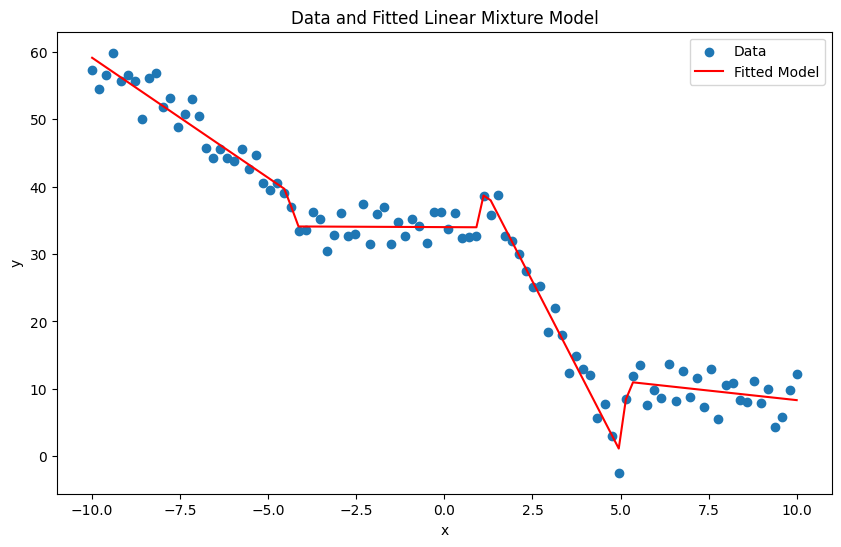

In [7]:
# Compute final predictions
y_pred = model_predictions(optimized_params, x_data)

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, y_pred, color='red', label='Fitted Model')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data and Fitted Linear Mixture Model')
plt.legend()
plt.show()


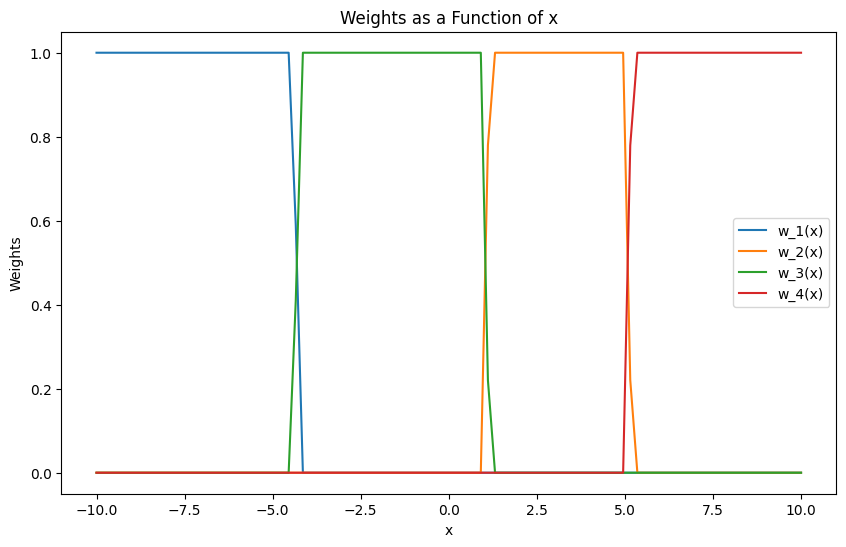

In [8]:
weights = np.zeros((len(x_data), 4))
for i in range(len(x_data)):
    xn = x_data[i]
    u = optimized_params[8:11]
    v = optimized_params[11:14]
    weights[i] = compute_weights(xn, u, v)

plt.figure(figsize=(10, 6))
for k in range(4):
    plt.plot(x_data, weights[:, k], label=f'w_{k+1}(x)')
plt.xlabel('x')
plt.ylabel('Weights')
plt.title('Weights as a Function of x')
plt.legend()
plt.show()


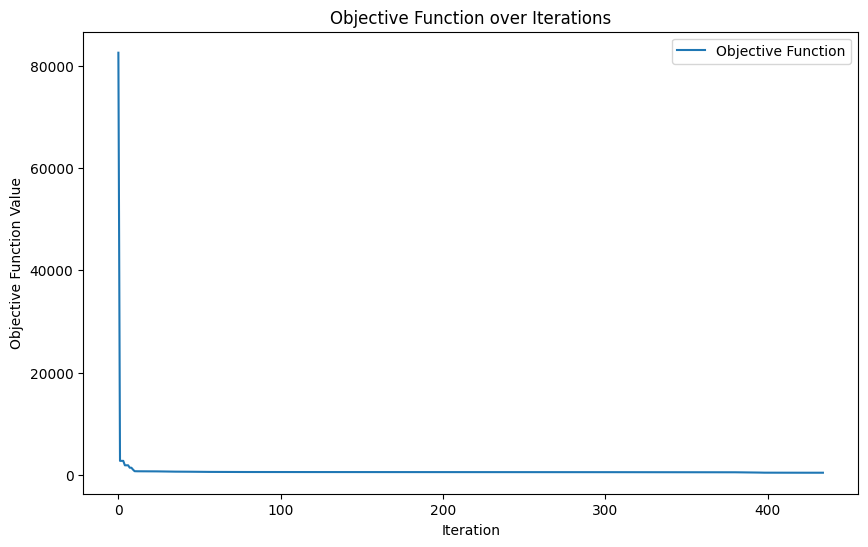

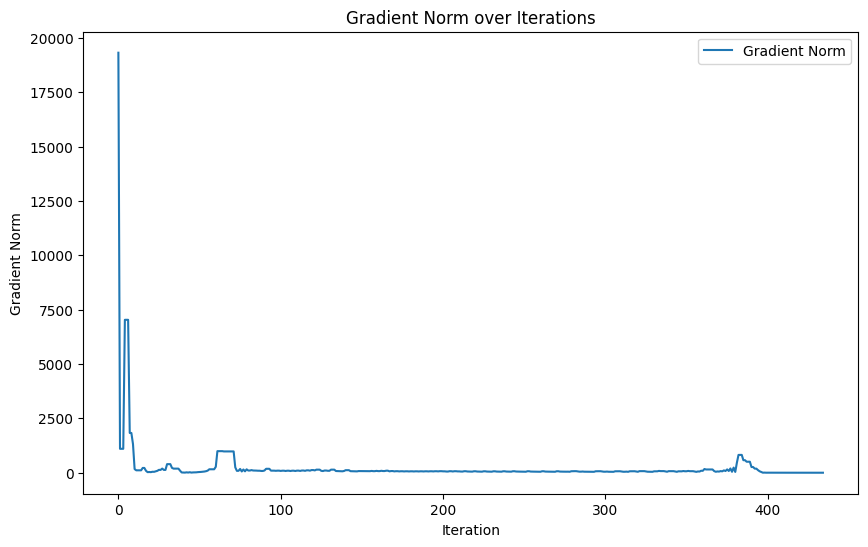

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(f_history, label='Objective Function')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Objective Function over Iterations')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(grad_norm_history, label='Gradient Norm')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm over Iterations')
plt.legend()
plt.show()
